In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
#read data
production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [4]:
production_ice_cream.rename('production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [5]:
#define start date
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream [start_date:]

# Visualize data

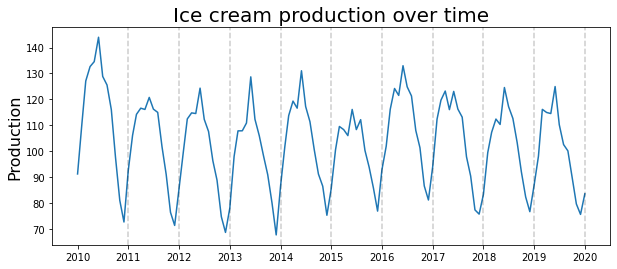

In [6]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice cream production over time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)


# ACF

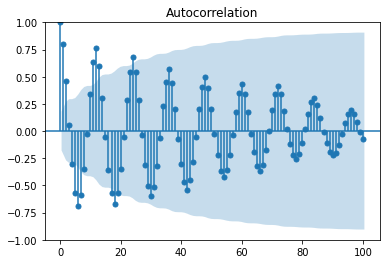

In [7]:
acf_plot = plot_acf(production_ice_cream, lags=100)

## Based on decaying ACF, we are likely dealing with an Auto Regressive process

# PACF

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


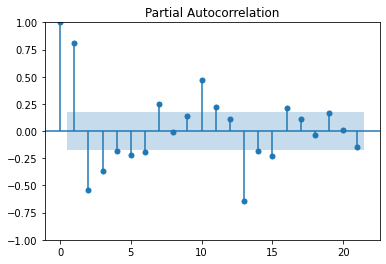

In [8]:
pacf_plot = plot_pacf(production_ice_cream)

## Based on PACF, we should start with an Auto Regressive model with lags 1, 2, and 3

# Get training and testing sets

In [9]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

# Fit the AR model

In [10]:
# create the model
model = ARIMA(train_data, order=(2,0,0))

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [11]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time is: ', end-start)

Model fitting time is:  0.042444467544555664


In [12]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                   84
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -300.882
Date:                Mon, 07 Nov 2022   AIC                            609.763
Time:                        20:07:09   BIC                            619.487
Sample:                    01-01-2010   HQIC                           613.672
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.4584      3.450     29.987      0.000      96.696     110.220
ar.L1          1.2526      0.106     11.762      0.000       1.044       1.461
ar.L2         -0.5427      0.129     -4.193      0.0

In [13]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [14]:
#get the predictions and residuals 
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

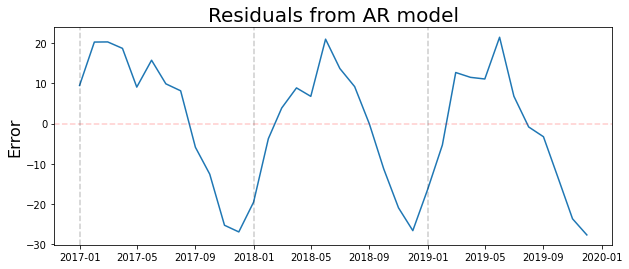

In [15]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle ='--', alpha =0.2)
for year in range(2017,2020):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

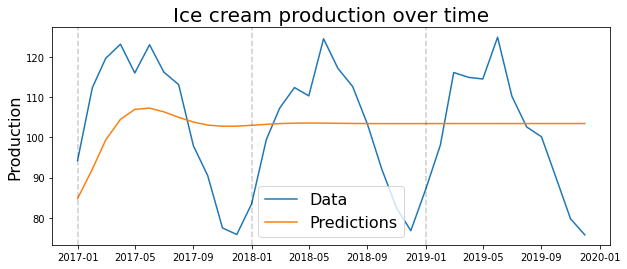

In [16]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)

plt.title('Ice cream production over time', fontsize=20)
plt.ylabel('Production', fontsize=16)

for year in range(2017,2020):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [17]:
print('Mean absolute percent error (MAPE):', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percent error (MAPE): 0.1397


In [18]:
print('Root mean squared error (RMSE):', np.sqrt(np.mean(residuals**2)))

Root mean squared error (RMSE): 15.461470172259173


# Rolling forecast origin

## Idea: predict one month in advance each time

### Train on months *1, 2, ..., k-3*                &rarr;  predict month *k-2*
### Train on months *1, 2, ..., k-3, k-2*         &rarr;  predict month *k-1*
### Train on months *1, 2, ..., k-3, k-2, k-1*  &rarr;  predict month *k*

### ...

### Average all predictions

In [19]:
#create the model
predictions_rolling = pd.Series()
for end_date in test_data.index:
    train_data = production_ice_cream[:end_date - timedelta(days=1)]
    model = ARIMA(train_data, order=(2,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date]=pred.loc[end_date]

C:\Users\user\AppData\Local\Temp/ipykernel_18000/2551548702.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling = pd.Series()
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: Valu

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: Valu

In [20]:
residuals_rolling = test_data - predictions_rolling

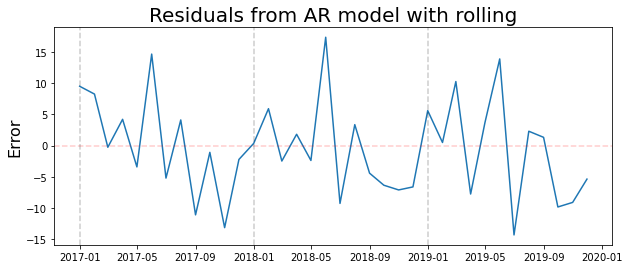

In [21]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR model with rolling', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle ='--', alpha =0.2)
for year in range(2017,2020):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

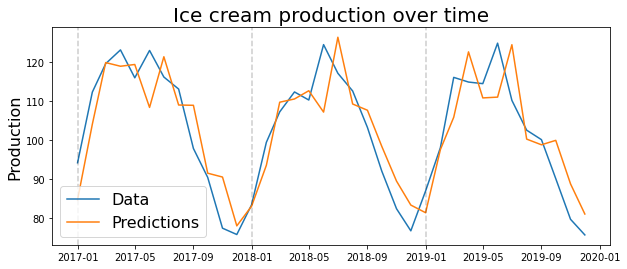

In [22]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions_rolling)

plt.legend(('Data','Predictions'), fontsize=16)

plt.title('Ice cream production over time', fontsize=20)
plt.ylabel('Production', fontsize=16)

for year in range(2017,2020):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [23]:
print('Mean absolute percent error (MAPE):', round(np.mean(abs(residuals_rolling/test_data)),4))

Mean absolute percent error (MAPE): 0.0624


In [24]:
print('Root mean squared error (RMSE):', np.sqrt(np.mean(residuals_rolling**2)))

Root mean squared error (RMSE): 7.7628605391808625
